In [1]:
import sys
import os
import datetime
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
# pqf = pq.ParquetFile(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd = pq.ParquetDataset(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd.files

['./context_data//competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00008-aba60f69-2b63-4cc1-95ca-

In [178]:
data_agg = None
for ifile in pqd.files :

    #data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/{ifile}')
    data = pq.read_table(f'{ifile}')
    #pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

    data_agg0 = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum"),('request_cnt', "mean"),])
    
    data_agg1 = data.select(['user_id','date', 'part_of_day', 'request_cnt']).\
        group_by(['user_id', 'date', 'part_of_day']).aggregate([('request_cnt', "sum")])
    
    data_agg2 = data.select(['user_id', 'city_name', 'region_name', 'cpe_model_os_type', 'price','request_cnt']).\
        group_by(['user_id', ]).\
        aggregate([('cpe_model_os_type', "max"), ('price', "max"), ('city_name', "max"), \
                   ('region_name', "max"),('request_cnt',"mean"),('request_cnt',"sum")])
    
    if data_agg is None :
        data_agg  = data_agg0
        data_aggB = data_agg1
        data_aggZ = data_agg2
        print(data.to_pandas().head())
    else :
        data_agg  = pa.concat_tables([data_agg, data_agg0],promote=False)
        data_aggB = pa.concat_tables([data_aggB,data_agg1],promote=False)
        data_aggZ = pa.concat_tables([data_aggZ,data_agg2],promote=False)
    
    del data, data_agg0, data_agg1, data_agg2
    
data_agg  = data_agg.to_pandas()
data_aggB = data_aggB.to_pandas()
data_aggZ = data_aggZ.to_pandas().fillna(0)

          region_name  city_name cpe_manufacturer_name cpe_model_name  \
0  Краснодарский край  Краснодар                 Apple       iPhone 7   
1  Краснодарский край  Краснодар                 Apple       iPhone 7   
2  Краснодарский край  Краснодар                 Apple       iPhone 7   
3  Краснодарский край  Краснодар                 Apple       iPhone 7   
4  Краснодарский край  Краснодар                 Apple       iPhone 7   

                      url_host cpe_type_cd cpe_model_os_type    price  \
0                ad.adriver.ru  smartphone               iOS  20368.0   
1                    apple.com  smartphone               iOS  20368.0   
2       avatars.mds.yandex.net  smartphone               iOS  20368.0   
3  googleads.g.doubleclick.net  smartphone               iOS  20368.0   
4  googleads.g.doubleclick.net  smartphone               iOS  20368.0   

         date part_of_day  request_cnt  user_id  
0  2022-06-15     morning            1    45098  
1  2022-06-19     morn

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [179]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32277669 entries, 0 to 32277668
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   request_cnt_sum   int64  
 1   request_cnt_mean  float64
 2   user_id           int64  
 3   url_host          object 
dtypes: float64(1), int64(2), object(1)
memory usage: 985.0+ MB


In [180]:
data_agg.columns, data_aggB.columns, data_aggZ.columns

(Index(['request_cnt_sum', 'request_cnt_mean', 'user_id', 'url_host'], dtype='object'),
 Index(['request_cnt_sum', 'user_id', 'date', 'part_of_day'], dtype='object'),
 Index(['cpe_model_os_type_max', 'price_max', 'city_name_max',
        'region_name_max', 'request_cnt_mean', 'request_cnt_sum', 'user_id'],
       dtype='object'))

In [188]:
aa=data_agg[['url_host','user_id']].groupby(['url_host']).count().sort_values('user_id',ascending=False).reset_index()

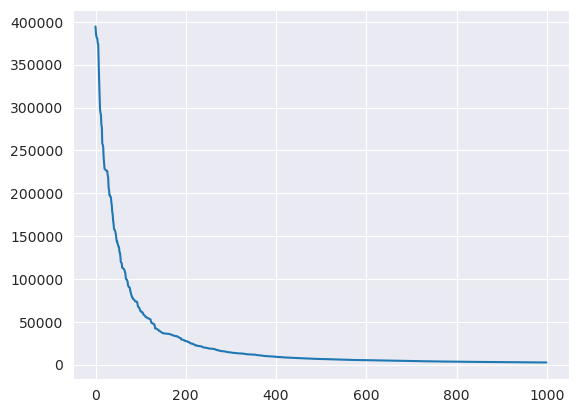

1

In [210]:
import matplotlib.pyplot as mat

mat.plot(aa.user_id[:1000]); 
mat.show()
aa.user_id[135000]

In [203]:
aa.shape

(199683, 2)

In [237]:
urls_hosts_max=data_agg[['url_host','user_id']].groupby(['url_host']).count().\
                sort_values('user_id', ascending=False)[135000:].reset_index()['url_host']

In [238]:
data_aggY = data_agg[~data_agg.url_host.isin(urls_hosts_max.to_list())]

In [239]:
len(data_agg), len(data_aggY), len(data_agg['user_id'].unique()), len(data_aggY['user_id'].unique())

(32277669, 32212986, 415317, 415317)

In [240]:
if 1 :
    
    data_aggC = data_aggZ[['user_id','price_max']]
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_sum']],
                                index='user_id', columns='part_of_day', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    if 0 :
        data_aggD = pd.get_dummies(data_aggZ.city_name_max,prefix='city')
        data_aggD['user_id'] = data_aggZ.user_id
        data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    if 0 :
        data_aggD = pd.get_dummies(data_aggZ.region_name_max,prefix='region')
        data_aggD['user_id'] = data_aggZ.user_id
        data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    data_aggD = pd.get_dummies(data_aggZ.cpe_model_os_type_max,prefix='os')
    data_aggD['user_id'] = data_aggZ.user_id
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

In [241]:
data_aggC.shape, data_aggC.columns

((415317, 44),
 Index(['user_id', 'price_max', 'day', 'evening', 'morning', 'night', 'DW0',
        'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DWPD0.day', 'DWPD0.evening',
        'DWPD0.morning', 'DWPD0.night', 'DWPD1.day', 'DWPD1.evening',
        'DWPD1.morning', 'DWPD1.night', 'DWPD2.day', 'DWPD2.evening',
        'DWPD2.morning', 'DWPD2.night', 'DWPD3.day', 'DWPD3.evening',
        'DWPD3.morning', 'DWPD3.night', 'DWPD4.day', 'DWPD4.evening',
        'DWPD4.morning', 'DWPD4.night', 'DWPD5.day', 'DWPD5.evening',
        'DWPD5.morning', 'DWPD5.night', 'DWPD6.day', 'DWPD6.evening',
        'DWPD6.morning', 'DWPD6.night', 'os_Android', 'os_Apple iOS', 'os_iOS'],
       dtype='object'))

In [242]:

if 1 :
    data_aggC['A']=data_aggC.day+data_aggC.evening+data_aggC.morning+data_aggC.night
    data_aggC['A000']=data_aggC.day/data_aggC.A
    data_aggC['A001']=data_aggC.evening/data_aggC.A
    data_aggC['A002']=data_aggC.morning/data_aggC.A
    data_aggC['A003']=data_aggC.night/data_aggC.A
    
if 1 :
    B000m=data_aggC.day.mean()
    B001m=data_aggC.evening.mean()
    B002m=data_aggC.morning.mean()
    B003m=data_aggC.night.mean()
    data_aggC['B000']=data_aggC.day/B000m
    data_aggC['B001']=data_aggC.evening/B001m
    data_aggC['B002']=data_aggC.morning/B002m
    data_aggC['B003']=data_aggC.night/B003m
    #data_aggC = data_aggC.drop(['day','morning','evening'],axis=1)
        
if 1 :
    DWA0  =data_aggC.DW0.median()
    DWA1  =data_aggC.DW1.median()
    DWA2  =data_aggC.DW2.median()
    DWA3  =data_aggC.DW3.median()
    DWA4  =data_aggC.DW4.median()
    DWA5  =data_aggC.DW5.median()
    DWA6  =data_aggC.DW6.median()
    data_aggC['DWB000']=data_aggC.DW0/DWA0
    data_aggC['DWB001']=data_aggC.DW1/DWA1
    data_aggC['DWB002']=data_aggC.DW2/DWA2
    data_aggC['DWB003']=data_aggC.DW3/DWA3
    data_aggC['DWB004']=data_aggC.DW4/DWA4
    data_aggC['DWB005']=data_aggC.DW5/DWA5
    data_aggC['DWB006']=data_aggC.DW6/DWA6
    
if 1 :
    data_aggC['DWA']=data_aggC.DW0+data_aggC.DW1+data_aggC.DW2+data_aggC.DW3+ \
                        data_aggC.DW4+data_aggC.DW5+data_aggC.DW6
    data_aggC['DW000']=data_aggC.DW0/data_aggC.DWA
    data_aggC['DW001']=data_aggC.DW1/data_aggC.DWA
    data_aggC['DW002']=data_aggC.DW2/data_aggC.DWA
    data_aggC['DW003']=data_aggC.DW3/data_aggC.DWA
    data_aggC['DW004']=data_aggC.DW4/data_aggC.DWA
    data_aggC['DW005']=data_aggC.DW5/data_aggC.DWA
    data_aggC['DW006']=data_aggC.DW6/data_aggC.DWA
    
data_aggC.shape, data_aggC.columns

((415317, 68),
 Index(['user_id', 'price_max', 'day', 'evening', 'morning', 'night', 'DW0',
        'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DWPD0.day', 'DWPD0.evening',
        'DWPD0.morning', 'DWPD0.night', 'DWPD1.day', 'DWPD1.evening',
        'DWPD1.morning', 'DWPD1.night', 'DWPD2.day', 'DWPD2.evening',
        'DWPD2.morning', 'DWPD2.night', 'DWPD3.day', 'DWPD3.evening',
        'DWPD3.morning', 'DWPD3.night', 'DWPD4.day', 'DWPD4.evening',
        'DWPD4.morning', 'DWPD4.night', 'DWPD5.day', 'DWPD5.evening',
        'DWPD5.morning', 'DWPD5.night', 'DWPD6.day', 'DWPD6.evening',
        'DWPD6.morning', 'DWPD6.night', 'os_Android', 'os_Apple iOS', 'os_iOS',
        'A', 'A000', 'A001', 'A002', 'A003', 'B000', 'B001', 'B002', 'B003',
        'DWB000', 'DWB001', 'DWB002', 'DWB003', 'DWB004', 'DWB005', 'DWB006',
        'DWA', 'DW000', 'DW001', 'DW002', 'DW003', 'DW004', 'DW005', 'DW006'],
       dtype='object'))

In [243]:
data_aggC.shape

(415317, 68)

In [244]:
if 0 :
    import matplotlib.pyplot as mp

    mp.hist(data_aggC.day, 100)
    mp.hist(data_aggC.morning, 100)
    mp.hist(data_aggC.evening, 100)
    #mp.hist(data_aggC.A003, 100)
    #mp.hist(data_aggC.DWB004, 100)

    mp.show()

    mp.hist(data_aggC.price_max,100)
    mp.show()

    mp.scatter(data_aggC.night,data_aggC['DWPD0.night'])
    mp.show()

In [219]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [220]:
import faiss

def set1 (items) :
    item_set = set(items)
    #print(f'{len(items)} items')
    item_dict = {item: iditem for item, iditem in zip(item_set, range(len(item_set)))}
    items_new = np.array(items.map(item_dict))
    return(item_dict, items_new)
    
def alsals (values, rows, cols, factors=50, iterations=30, clusters=400) :
    
    #values = np.array(data_agg['request_cnt_sum'])
    #rows   = np.array(data_agg['user_id'].map(usr_dict))
    #cols   = np.array(data_agg['url_host'].map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = iterations, \
           use_gpu = False, nlist=clusters, \
           calculate_training_loss = False, regularization = 0.1)
    als.fit(mat)
    u_factors = als.model.user_factors 
    d_factors = als.model.item_factors
    
    return u_factors

def doMatrix (users, items, values, clusters=400, factors=50, iterations=30) :
    users_dict, users_new = set1(users)
    items_dict, items_new = set1(items)

    uu = alsals(values,users_new,items_new, clusters=clusters, factors=factors, iterations=iterations)
    uu = pd.DataFrame(uu)

    inv_users_dict = {v: k for k, v in users_dict.items()}
    uu['user_id'] = uu.index.map(inv_users_dict)
    return uu

In [288]:
%%time

if 0 :
    u3 = doMatrix(data_aggB.user_id, data_aggB.date,            data_aggB.request_cnt_sum, clusters=10, factors=50)
    u0 = doMatrix(data_agg.user_id,  data_agg.url_host,         data_agg.request_cnt_sum, clusters=400, factors=250)

    u1 = doMatrix(data_aggZ.user_id, data_aggZ.region_name_max, data_aggZ.request_cnt_mean, clusters=5)
    u2 = doMatrix(data_aggZ.user_id, data_aggZ.city_name_max,   data_aggZ.request_cnt_mean, clusters=20)

u12= doMatrix(pd.concat([data_aggZ.user_id,data_aggZ.user_id,data_agg.user_id,data_agg.user_id],ignore_index=True),
              pd.concat([data_aggZ.region_name_max,data_aggZ.city_name_max,data_agg.url_host,\
                         data_agg.url_host,],ignore_index=True),\
              pd.concat([data_aggZ.request_cnt_mean,data_aggZ.request_cnt_mean,data_agg.request_cnt_sum,\
                         data_agg.request_cnt_mean,],\
                        ignore_index=True),
              clusters=400, factors=650)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 2h 22min 13s, sys: 10.4 s, total: 2h 22min 23s
Wall time: 19min 1s


In [289]:
u12.shape

(415317, 651)

## Получим оценку по полу

In [290]:
%%time
'''
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
'''

usr_emb = u12
'''
print(len(u1),len(u0),len(usr_emb))
usr_emb = usr_emb.merge(u0, how = 'inner', on = ['user_id'], suffixes=('_u0', '_u1') )
usr_emb = usr_emb.merge(u1, how = 'inner', on = ['user_id'], suffixes=('_u0', '_u1') )
usr_emb = usr_emb.merge(u2, how = 'inner', on = ['user_id'], suffixes=('_u12','_u2') )
#usr_emb = usr_emb.merge(u3, how = 'inner', on = ['user_id'], suffixes=('_u23','_u3') )

#usr_emb = usr_emb.merge(u12, how = 'inner', on = ['user_id'], suffixes=('_u20','_u21') )

#usr_emb = usr_emb.fillna(-1)
'''
#usr_emb = usr_emb.fillna(-1)

usr_emb = usr_emb.merge(data_aggC, how = 'inner', on = ['user_id'], suffixes=('_u12','_aggC'))
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb,   how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 6.25 s, sys: 1.12 s, total: 7.37 s
Wall time: 7.36 s


1    135331
0    128994
Name: is_male, dtype: int64

In [291]:
#u0[u0.isna()==True].shape, len(u0)
#usr_emb[usr_emb[['0_u0']].isna()]

In [292]:
#df1 = df
#df = df.drop('price_max',axis=1)
df.shape

(264325, 720)

In [293]:
df.shape #, df.columns[:100]

(264325, 720)

In [294]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

2023-02-23 23:58:52.053834
GINI по полу 0.690
CPU times: user 19min 19s, sys: 16.6 s, total: 19min 36s
Wall time: 2min 34s


In [295]:
%%time
print(datetime.datetime.now())
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

2023-02-24 00:01:26.394172
CPU times: user 26min 17s, sys: 18.6 s, total: 26min 36s
Wall time: 3min 29s


In [296]:
df.shape

(264325, 720)

## Получим оценку по возрасту

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [298]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

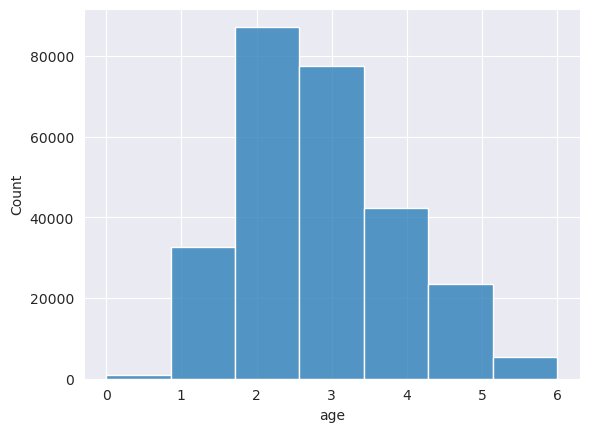

In [299]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [300]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

2023-02-24 00:04:58.731235
              precision    recall  f1-score   support

         <18       0.50      0.01      0.01       349
       18-25       0.52      0.32      0.40     10663
       25-34       0.49      0.63      0.55     28815
       35-44       0.40      0.51      0.45     25791
       45-54       0.37      0.22      0.28     13931
       55-65       0.41      0.21      0.28      7688
         65+       0.42      0.02      0.03      1849

    accuracy                           0.44     89086
   macro avg       0.45      0.27      0.29     89086
weighted avg       0.44      0.44      0.42     89086

CPU times: user 2h 20min 14s, sys: 14.6 s, total: 2h 20min 29s
Wall time: 18min 13s


f1 0.00 0.40 0.54 0.45 0.27 0.28 0.03 - 0.44 0.28 0.42 (als = 250.30 without)

In [301]:
%%time
print(datetime.datetime.now())
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

2023-02-24 00:23:12.324272
CPU times: user 3h 14min 39s, sys: 17.1 s, total: 3h 14min 56s
Wall time: 25min 16s


In [302]:
df.shape

(269957, 720)

## Сабмит

In [303]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.967090,2
31271,31271,0.479925,3
211594,211594,0.473637,2
253119,253119,0.476407,2
192578,192578,0.863117,2


In [308]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission12.csv', index = False)

In [309]:
! head $LOCAL_DATA_PATH/submission1.csv

user_id,is_male,age
221301,0.9523721503994212,2
31271,0.540058202285835,3
211594,0.4921148361193288,2
253119,0.5031936669434278,2
192578,0.7343094598406392,2
268458,0.28223318330597313,2
205507,0.5256998725263032,3
341343,0.6329608219845485,3
282144,0.026135216529779966,2


# Скор на лидерборде

In [187]:
#context_scorer(submission, answers)

In [306]:
xx=clf.get_feature_importance(prettified=True)

In [307]:
xx.head(50)

,Feature Id,Importances
0,price_max,1.673456
1,506,1.175395
2,260,0.992470
3,526,0.928055
4,432,0.898241
5,405,0.849169
6,345,0.831763
7,354,0.778013
8,201,0.767544
9,67,0.756516
